In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, re

def batch_convert_folder(folder_path, extension=".txt", mute = False):
    """
    Converts all .dat files in a folder to .txt step profiles.
    Saves outputs next to input files.
    Parameters:
        folder_path (str): Path to directory with .dat files
        extension (str): Output extension
    """
    files = [f for f in os.listdir(folder_path) if f.endswith(".dat")]
    data = {}
    for fname in files:
        file_path = os.path.join(folder_path, fname)
        z = convert_dat(file_path, extension, mute)
        data.update({fname:z})
    return data

def batch_convert_file(file, extension=".txt", mute = False):
    """
    Converts .dat file(s) to .txt step profiles.
    Saves outputs next to input files.
    Parameters:
        file (str/list): Path to directory with .dat file
        extension (str): Output extension
    """
    if isinstance(file,list):
        files = file
    else:
        files = [file]
    data = {}
    for file_path in files:
        fname = os.path.basename(file_path)
        z = convert_dat(file_path, extension, mute)
        data.update({fname:z})
    return data   

def convert_dat(file_path, extension=".txt", mute = False):
    try:
        z = P7_dat2Z(file_path)
        folder_path = os.path.dirname(file_path)
        fname = os.path.basename(file_path)
        output_name = os.path.splitext(fname)[0] + extension
        out_path = os.path.join(folder_path, output_name)
        data = np.column_stack((np.arange(len(z)),z))
        np.savetxt(out_path, data, fmt="%.3f",delimiter='\t\t\t',header="Points\t\t\tZ (nm)\t\t\t")
        if not mute:
            print(f"Saved: {output_name}")
        return np.array(z)
    except Exception as e:
        print(f"Failed on {fname}: {e}")


def decode_fixed_point(int_part, frac_part):
    # frac_part is signed int16 → convert to unsigned uint16 interpretation
    frac_unsigned = frac_part.astype('uint16')
    return int_part + frac_unsigned / 65536.0

def auto_detect_data_block_after_zeros(data, zero_run=2000, jump_thresh=10000):
    """
    Detect the start of the Z data block, not very elegant but works.
    Parameters:
        data (np.ndarray): int16 array of the .dat file
        zero_run (int): number of consecutive zeros to search for
        window (int): window size for std dev scan
        std_thresh (float): minimum std dev to detect structured data
        jump_thresh (float): jump threshold in Z_int to detect block end

    Returns:
        (start, end): start and end in the detected block
    """
    last_zero_index = None

    # Step 1: Find the last run of zeros: Start point
    for i in range(len(data) - zero_run):
        if np.all(data[i:i + zero_run] == 0):
            last_zero_index = i
    if last_zero_index is None:
        return None, None
    start_scan = last_zero_index + zero_run

    # Step 2: Attempt to detect sharp jump in Z_int part: End point
    for j in range(start_scan, len(data), 2):
        segment = data[j:]
        z_int = segment[1::2]  # assume int-frac alignment
        dz = np.diff(z_int)
        jumps = np.where(np.abs(dz) > jump_thresh)[0]
        if len(jumps) > 0:
            end = j + 2 * (jumps[0] + 1)
            return j, end  # start, end
    return None, None

def scale_from_recipe(raw):
    """Extract KLA P-7 .dat binary file to extract recipe and scaling factor accordingly.
    Parameters:
        raw binary file 
    Returns:
        Scaling factor regarding different measurement range:
        13um/0.0078A range:     x6.4
        131um/0.0781A:          x102.4
        1048um/0.6250A:         x6.4 
    """
    if b'Z_13UM' in raw:
        return 64/10
    elif b'Z_131UM' in raw:
        return 1024/10
    elif b'Z_1048UM' in raw:
        return 64/10
    else:
        print('Unknown recipe, please scale your data with\n        x6.4 for 13um/0.0078A range\n       x102.4 for 131um/0.0781A\n       x6.4 for 1048um/0.6250A\n')
        return 1

def P7_dat2Z(file_path):
    """Decode KLA P-7 .dat binary file to extract Z arrays.
    Parameters:
        file_path (str): Path to .dat file
    Returns:
        z (np.ndarray): Z heights (Å)
    Assume:
        frac-int format
    """
    with open(file_path, "rb") as f:
        raw = f.read()
    data = np.frombuffer(raw, dtype='<i2')
    # print(raw)
    start, end = auto_detect_data_block_after_zeros(data)
    # print(start,end)
    block = data[start:end]
    z_int = block[1::2]
    z_frac = block[0::2]
    min_len = min(len(z_int),len(z_frac))
    z = decode_fixed_point(z_int[:min_len], z_frac[:min_len])
    scale = scale_from_recipe(raw)
    return -np.array(z-z[0])*scale

In [57]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

def measure_step_height(z, sigma=10, threshold=0.5 , plot=False):
    """
    Measure step height from 1D profilometer data under ISO 25178-style leveling.

    Parameters:
    -----------
    z : 1D numpy array
        Height profile (raw).
    sigma : float
        Sigma for gaussian smoothing
    threshold : float
        percentage for find peaks, default= 0.1
    manual_ratio : float
        Used if auto_segment is False. Fraction of points to average on each side.
    plot : bool
        Whether to show a diagnostic plot.

    Returns:
    --------
    step_height : float
        Estimated step height in same units as `z`.
    """
    x = np.arange(len(z))
    z_smooth = gaussian_filter1d(z, sigma=sigma)
    dzdx = np.gradient(z_smooth, 1)

    # Find rising edges
    rise_peaks, _ = find_peaks(dzdx, prominence=threshold*np.max(np.abs(dzdx)))
    # Find falling edges
    fall_peaks, _ = find_peaks(-dzdx, prominence=threshold*np.max(np.abs(dzdx)))

    # Pair rising and falling edges
    pairs = []
    if len(rise_peaks)==0:
        if len(fall_peaks)==0:
            raise ValueError("Auto-segmentation failed. Use manual method instead.")
        else:
            pairs.append((min(x),fall_peaks[0]))
    else:
        for r in rise_peaks:
            f_candidates = fall_peaks[fall_peaks > r]
            if len(f_candidates) == 0:
                pairs.append((r,max(x)))
                continue
            f = f_candidates[0]
            pairs.append((r, f))

    # Level the profile using edge regions ---
    mask = np.zeros(len(z), dtype=bool)
    for r, f in pairs:
        mask[r:f] = True  # mark step regions
    x_fit = x[~mask]
    z_fit_input = z[~mask]
    coeffs = np.polyfit(x_fit, z_fit_input, 1)
    z_fit = np.polyval(coeffs, x)
    z_flat = z - z_fit

    heights = []
    profile = []
    for r, f in pairs:
        left = z_flat[max(0, r - 10):r]
        middle = z_flat[r:f]
        right = z_flat[f:min(len(z), f + 10)]
        low = np.mean(left)
        high = np.mean(middle)
        profile.append((r,f,low,high))
        if len(left) > 0 and len(middle) > 0:
            h = high - low
            heights.append(h)

    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 4))
        plt.plot(x, z, label='Raw')
        plt.plot(x, z_smooth, label='Smoothed')
        plt.plot(x, z_flat, label='Gradient')
        plt.scatter(x[rise_peaks], z_flat[rise_peaks], label='Rising', c='g')
        plt.scatter(x[fall_peaks], z_flat[fall_peaks], label='Falling', c='r')
        for r, f, low, high in profile:
            plt.fill_between(x, low, high, where=(x>r)&(x<f), color='orange', alpha=0.2)
        plt.title(f"Mean Step Height = {np.mean(heights):.2f} nm (over {len(heights)} steps)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return np.average(heights)



In [58]:
# Example 1: Batch convert .dat files to txt
#            a)   Method: Convert the whole folder
print("--Folder Convertion")
folder = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250716_Unifomity_forCorr_45deg_5As_1000A\data"
folder_data = batch_convert_folder(folder)
#            b)   Method: Convert the idividual file
print("--Individual file Convertion")
file = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250716_Unifomity_forCorr_45deg_5As_1000A\data\0mm.dat"
file_data = batch_convert_file(file)
#            c)   Method: Convert the list of files
print("--List of files Convertion")
files = [r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250716_Unifomity_forCorr_45deg_5As_1000A\data\0mm.dat",
         r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250716_Unifomity_forCorr_45deg_5As_1000A\data\2mm.dat"]
files_data = batch_convert_file(files)

--Folder Convertion
Saved: 0mm.txt
Saved: 0mm_SIMPLE.txt
Saved: 10mm.txt
Saved: 12mm.txt
Saved: 14mm.txt
Saved: 16mm.txt
Saved: 18mm.txt
Saved: 20mm.txt
Saved: 22mm.txt
Saved: 24mm.txt
Saved: 2mm.txt
Saved: 4mm.txt
Saved: 6mm.txt
Saved: 8mm.txt
--Individual file Convertion
Saved: 0mm.txt
--List of files Convertion
Saved: 0mm.txt
Saved: 2mm.txt


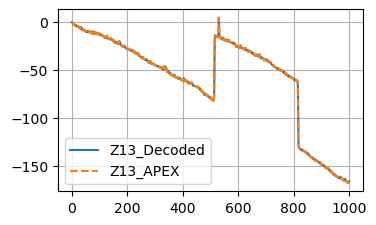

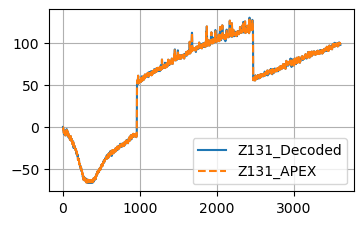

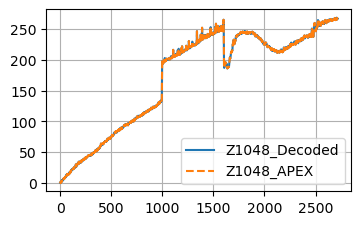

In [59]:
# Example 2: APEX .txt comparison from \ExampleFiles folder
example_folder_path = "ExampleFiles"
fname_list = ['Z13','Z131','Z1048']
for fname in fname_list:
    plt.figure(figsize=(10/2.54, 6/2.54))
    decoded = P7_dat2Z(os.path.join(example_folder_path,fname+'.dat'))
    apex_df = pd.read_csv(os.path.join(example_folder_path,fname+'_APEX.txt'), sep=r"\s+", header=None, names=["x", "z"])
    plt.plot(decoded, label=fname + "_Decoded")
    plt.plot(apex_df['z'] - apex_df['z'][0], '--', label=fname + "_APEX")
    plt.legend()
    plt.grid()
    plt.show()


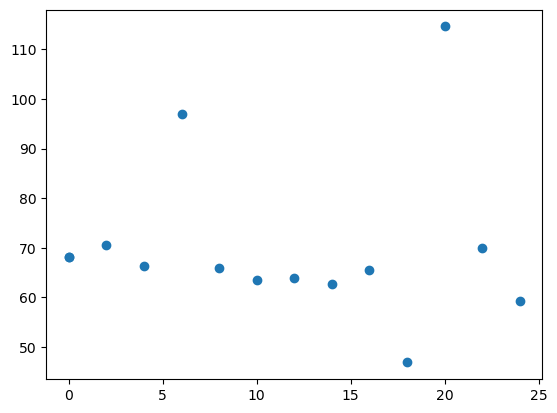

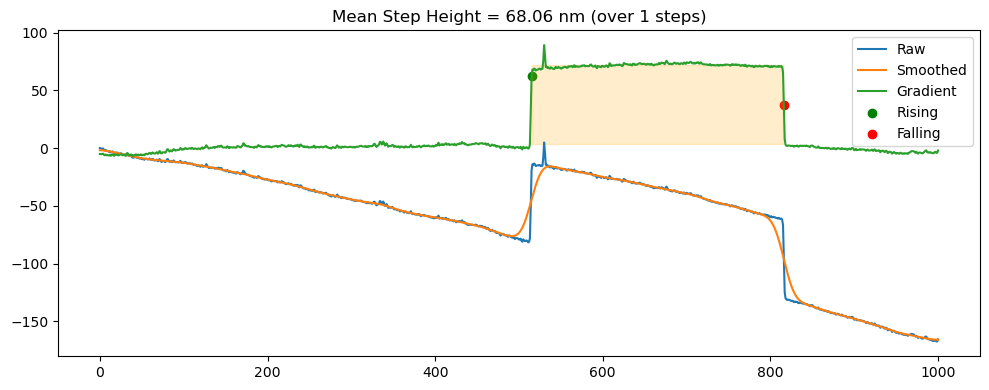

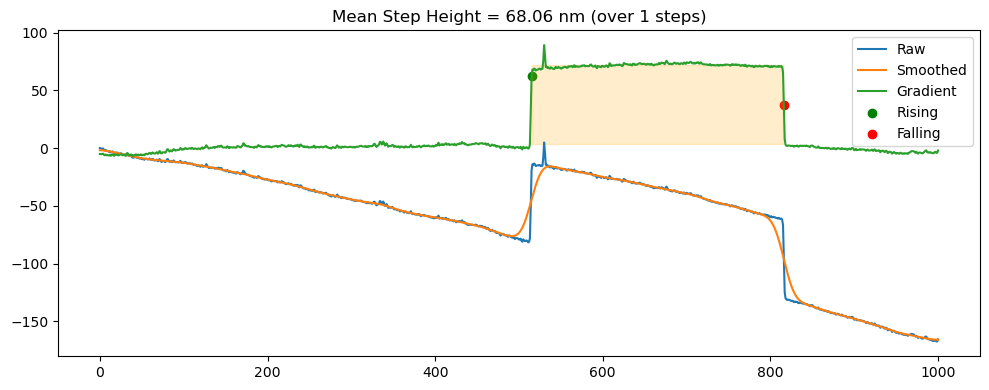

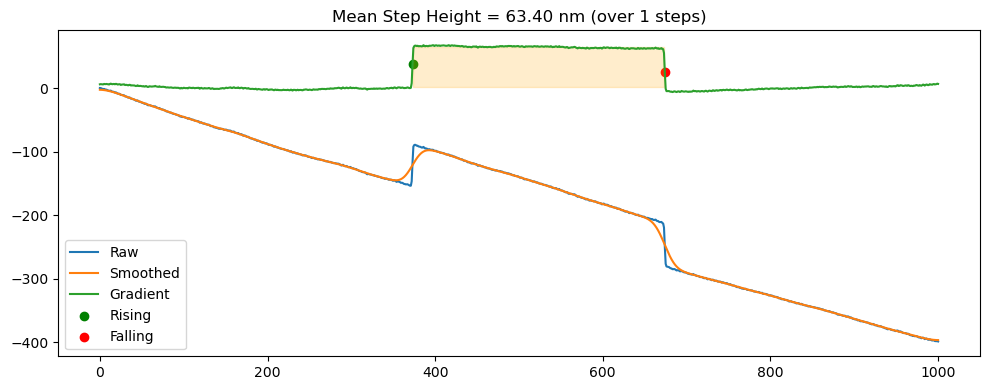

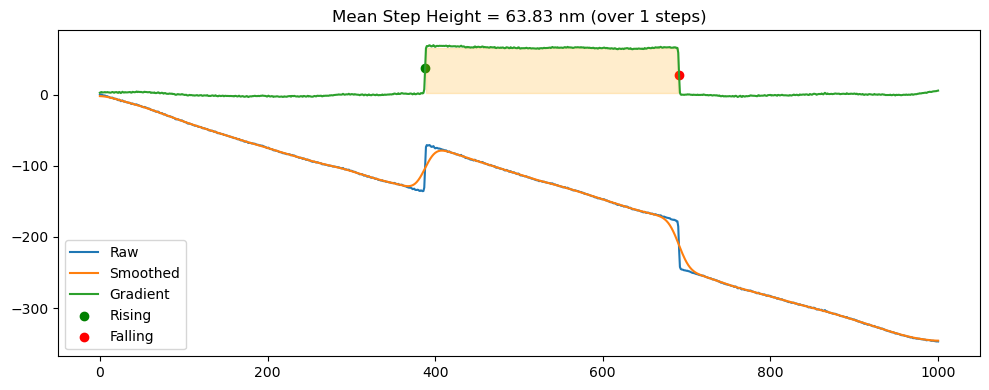

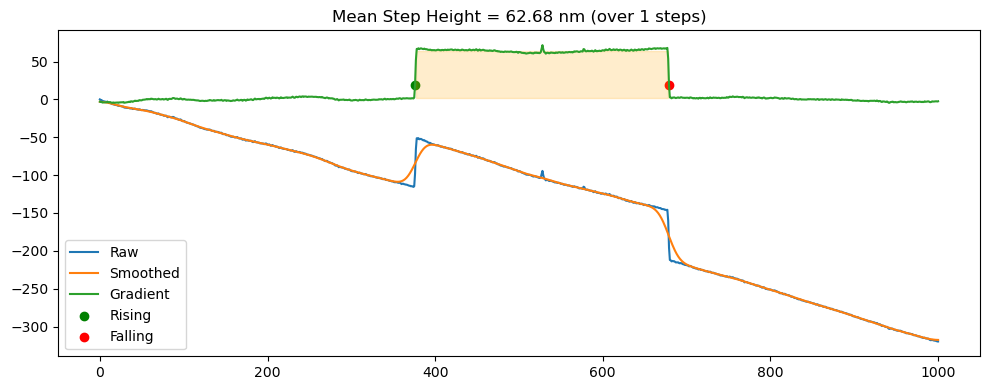

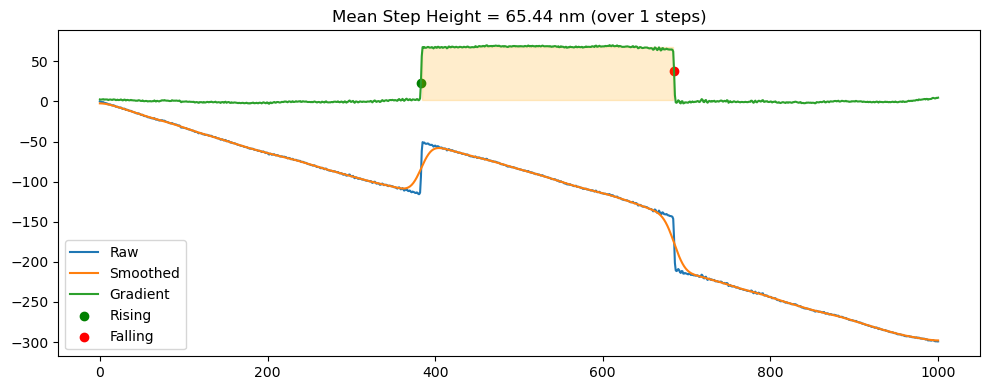

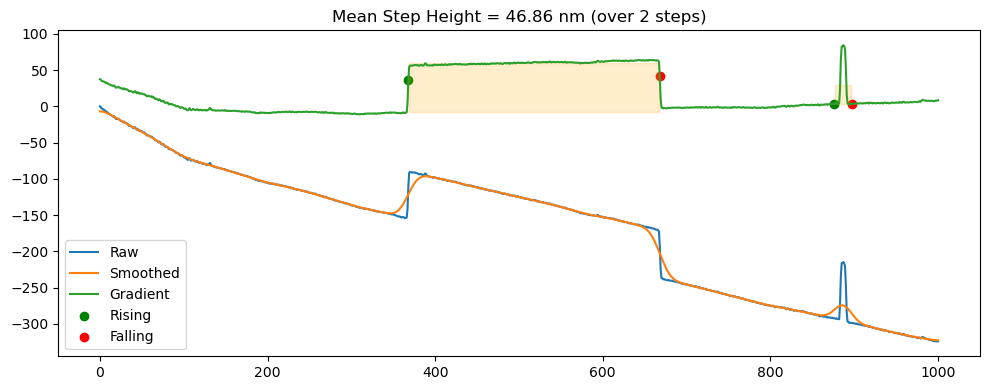

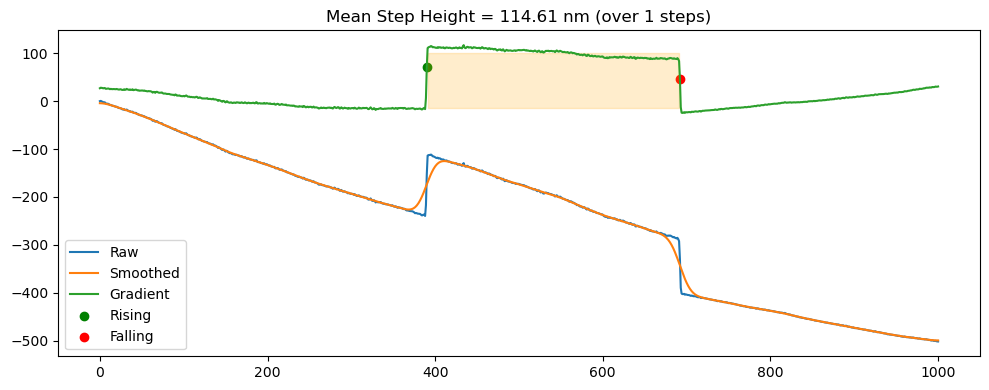

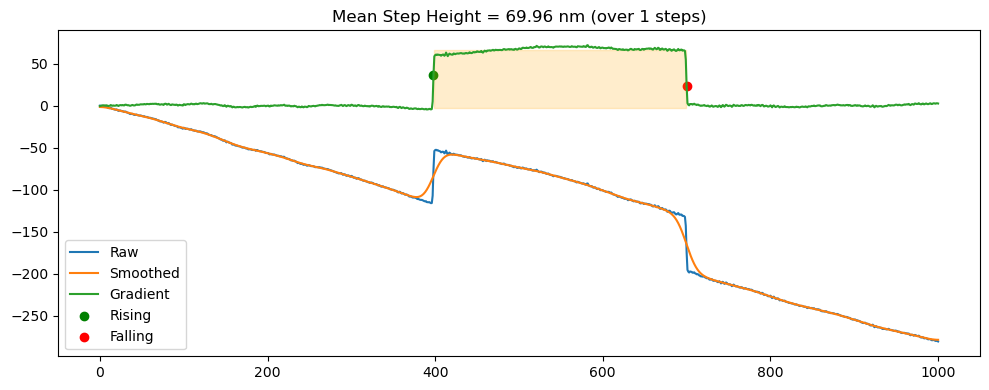

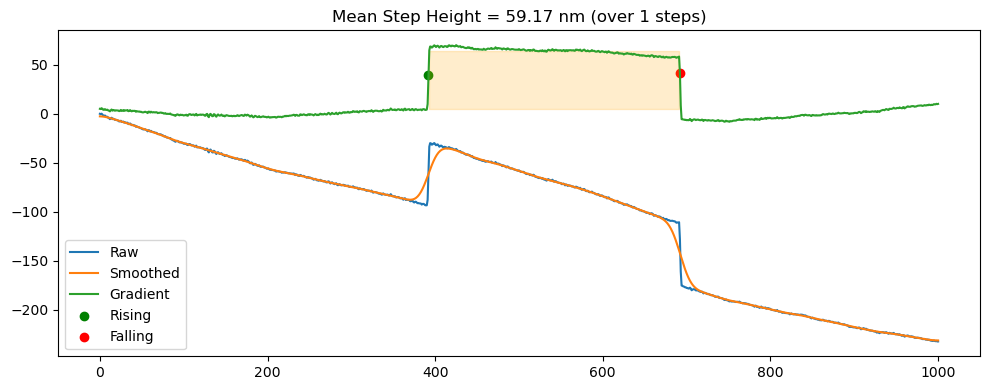

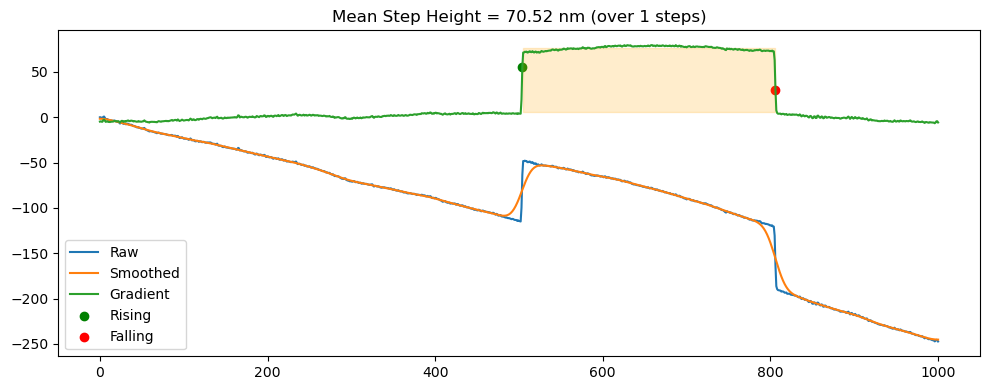

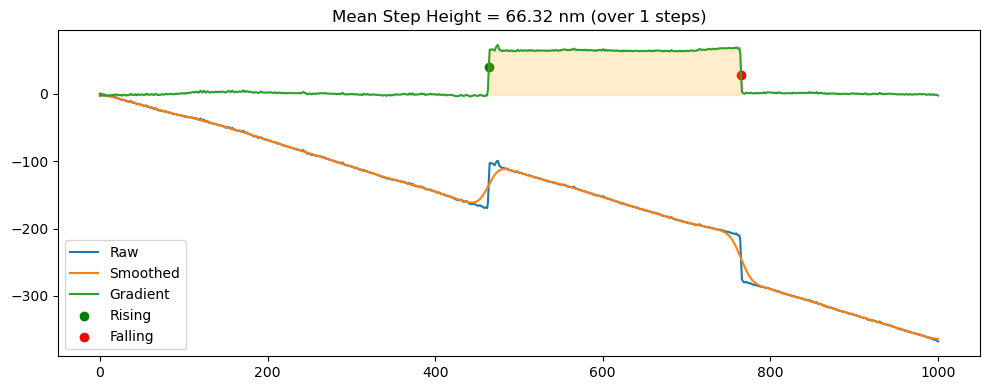

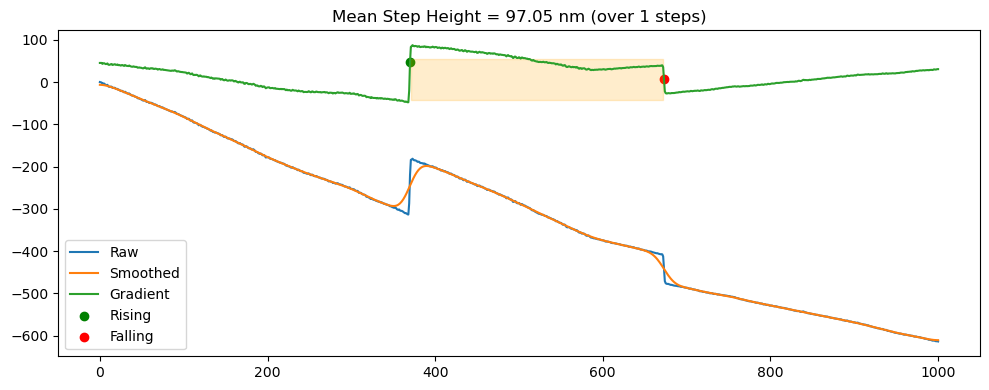

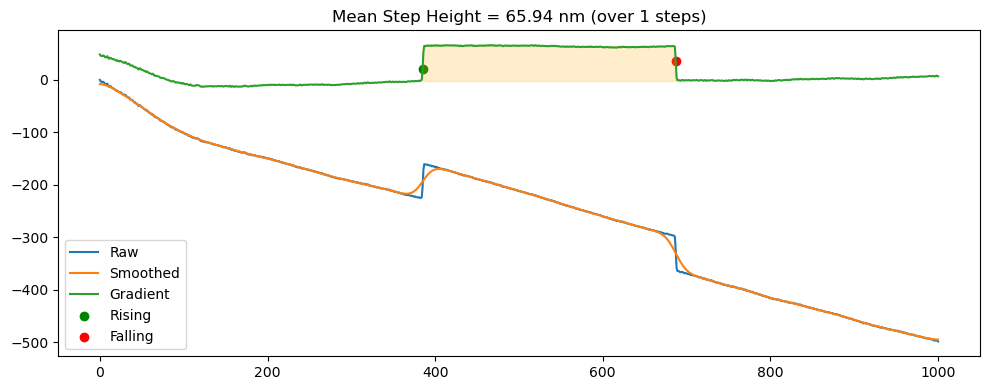

In [60]:
# Example 3: level the z and auto process step height
folder = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250716_Unifomity_forCorr_45deg_5As_1000A\data"
folder_data = batch_convert_folder(folder, mute=True)
# - Mute plot and alarm export the height value
position = []
height = []
for key, value in folder_data.items():
    step = measure_step_height(value, plot=False)
    position.append(float(re.findall(r'\d+', key)[0]))
    height.append(step)
plt.scatter(position,height)
plt.show()
# - Plot for visualization
for key, value in folder_data.items():
    step = measure_step_height(value, plot=True)